In [246]:
# temp_rf.py
# Avery Krieger 11/2022, adapted components from Tim Currier and Max Turner

# argumenmts: [1] date (yyyy-mm-dd); [2] series_number; [3] roi_set_name
# implementation: save_strfs.py 2022-03-17 1 roi_set_postfrom visanalysis.analysis import imaging_data, shared_analysis

import os
from pathlib import Path

import matplotlib.patches as mpatches  # for the legend patches
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from scipy import interpolate
from two_photon_analysis import medulla_analysis as ma
from visanalysis.analysis import imaging_data, shared_analysis

# User defined parameters

In [247]:
# define recording series to analyze
experiment_file_directory = "/Volumes/ROG2TBAK/data/bruker/20221025"
experiment_file_name = "2022-10-25"  # sys.argv[1]
series_number = "1"  # int(sys.argv[2])
roi_set_name = "Mi1_proximal_mixed"  # sys.argv[3]

filter_length = 2
dff = True
savefig = True

# Data Loading

In [248]:
# join path to proper format for ImagingDataObject()
file_path = os.path.join(experiment_file_directory, experiment_file_name + ".hdf5")
print(file_path)
# create save directory
save_directory = "/Volumes/ROG2TBAK/data/bruker/trfs/" + experiment_file_name + "/"
print(save_directory)
Path(save_directory).mkdir(exist_ok=True)
# create ImagingDataObject (wants a path to an hdf5 file and a series number from that file)
ID = imaging_data.ImagingDataObject(file_path, series_number, quiet=True)

# get ROI timecourses and stimulus parameters
roi_data = ID.getRoiResponses(roi_set_name)
ID.getRoiSetNames()

/Volumes/ROG2TBAK/data/bruker/20221025/2022-10-25.hdf5
/Volumes/ROG2TBAK/data/bruker/trfs/2022-10-25/


['Mi1_proximal_big_opto_response',
 'Mi1_proximal_mixed',
 'Mi1_proximal_small_opto_response',
 'proximal_roi1',
 'proximal_roi2',
 'proximal_z1',
 'proximal_z2',
 'proximal_z2_one_roi']

# Interpolation of the ROI response trace into sample period time

In [237]:
roi_ind = 0
response_trace = roi_data.get('roi_response')[roi_ind][0, :]
response_time = np.arange(1, len(response_trace)+1) * ID.getAcquisitionMetadata('sample_period')
# Interpolation function to interpolate response. Fxn built using sample period
f_interp_response = interpolate.interp1d(response_time, response_trace)

# Recreate visual stimuli from stored seeds and fft responses to generate filters

In [238]:
# same as above, but accounting for multiple ROIs

# Function to randomly draw a value
def getRandVal(rand_min, rand_max, start_seed, update_rate, t):
  seed = int(round(start_seed + t*update_rate))
  np.random.seed(seed)
  return np.random.choice([rand_min, (rand_min + rand_max)/2, rand_max], size=1)[0]

# Establish relevant variables
epoch_parameters = ID.getEpochParameters()
ideal_frame_rate = 120  # Hz
sample_period = ID.getAcquisitionMetadata('sample_period') # (sec), bruker imaging acquisition period
filter_len = filter_length * ideal_frame_rate
stimulus_timing = ID.getStimulusTiming(plot_trace_flag=False)
stimulus_start_times = stimulus_timing['stimulus_start_times']
run_parameters = ID.getRunParameters
stim_frames = run_parameters('stim_time') * ideal_frame_rate

# frame flip times in a stimulus presentation:
stim_times = np.arange(1, stim_frames+1) * 1/ideal_frame_rate

# Initialize roi_trfs - ROI x Filter x Trials
roi_trfs = np.zeros(
    (
        roi_data["epoch_response"].shape[0],
        int(filter_len),
        int(run_parameters("num_epochs")),
    )
)
all_stims = []
all_responses = []

print('\n----------------------------------------------------------------------------------')
print('Initializing: (1) visual stim recreation (2) fft responses (3) generate filters...\n')

for epoch_ind in range(int(ID.getRunParameters('num_epochs'))):
    if epoch_ind%10 == 0:
        print(f'...Starting Trial {epoch_ind} of {int(ID.getRunParameters("num_epochs"))}...')
    for roi_ind in range(0, roi_data["epoch_response"].shape[0]):
        # initalize trf by trial array (T, trial)
        roi_trf = np.zeros((int(filter_len), int(run_parameters("num_epochs"))))
        
        response_trace = roi_data.get('roi_response')[roi_ind][0, :]
        response_time = np.arange(1, len(response_trace)+1) * ID.getAcquisitionMetadata('sample_period')
        # Interpolation function to interpolate response. Fxn built using sample period
        f_interp_response = interpolate.interp1d(response_time, response_trace)

        # Regenerate the stimulus
        start_seed = epoch_parameters[epoch_ind]['start_seed']
        rand_min = eval(epoch_parameters[epoch_ind]['distribution_data'])['kwargs']['rand_min']
        rand_max = eval(epoch_parameters[epoch_ind]['distribution_data'])['kwargs']['rand_max']
        update_rate = epoch_parameters[epoch_ind]['update_rate']

        new_stim = np.array([getRandVal(rand_min, rand_max, start_seed, update_rate, t) for t in stim_times])
        current_frame_times = stimulus_start_times[epoch_ind] + stim_times  # In Prairie View time (sec)

        baseline_time = 1 # (sec) generally could be pre_time, but for opto only take previous 1 sec
        baseline_times = np.linspace(current_frame_times[0]-baseline_time, current_frame_times[0], int(1/sample_period))
        baseline = np.mean(f_interp_response(baseline_times))

        if dff == True:
            # Convert to dF/F
            current_interp_response = (f_interp_response(current_frame_times) - baseline) / baseline
        else: # don't df/f
            current_interp_response = f_interp_response(current_frame_times) 

        filter_fft = np.fft.fft(current_interp_response - np.mean(current_interp_response)) * np.conj(
          np.fft.fft(new_stim - np.mean(new_stim)))

        filt = np.real(np.fft.ifft(filter_fft))[0 : int(filter_len)]

        trf = np.flip(filt)
        
        #roi_trf[:, epoch_ind] = trf
        roi_trfs[roi_ind, :, epoch_ind] = trf

#all_trfs = np.stack(all_trfs, axis=-1)
print('\n-------')
print('DONE!')
print('-------\n')


----------------------------------------------------------------------------------
Initializing: (1) visual stim recreation (2) fft responses (3) generate filters...

...Starting Trial 0 of 150...
...Starting Trial 10 of 150...
...Starting Trial 20 of 150...
...Starting Trial 30 of 150...
...Starting Trial 40 of 150...
...Starting Trial 50 of 150...
...Starting Trial 60 of 150...
...Starting Trial 70 of 150...
...Starting Trial 80 of 150...
...Starting Trial 90 of 150...
...Starting Trial 100 of 150...
...Starting Trial 110 of 150...
...Starting Trial 120 of 150...
...Starting Trial 130 of 150...
...Starting Trial 140 of 150...

-------
DONE!
-------



# Split into opto/no opto and get some standard error of the means

In [239]:
# SPLIT into NO Opto and YES Opto trials (alternating)
no_slice = roi_trfs[:, :, 0::2]  # Every 2 trials, starting at 0
yes_slice = roi_trfs[:, :, 1::2]  # Every 2 trials, starting at 1

# compute mean STRF
# roi_mean_strf = np.mean(roi_strf,3);
roi_mean_trf = np.mean(roi_trfs, 2)
nopto_mean_trf = np.mean(no_slice, 2)
yopto_mean_trf = np.mean(yes_slice, 2)

# Standard Error of the Mean calculations
nopto_sem = sem(no_slice, axis=2)  # calculate the no opto sem
nopto_sem_plus = np.squeeze(nopto_mean_trf + nopto_sem)
nopto_sem_minus = np.squeeze(nopto_mean_trf - nopto_sem)
yopto_sem = sem(yes_slice, axis=2)  # calculate the yes opto sem
yopto_sem_plus = np.squeeze(yopto_mean_trf + yopto_sem)
yopto_sem_minus = np.squeeze(yopto_mean_trf - yopto_sem)

# Checking ouputs for separating no opto from opto trials
print("\n----------------------------------------------------------------------------")
print("----------------------------------------------------------------------------")
print("||    Checking the shape of the various trfs to ensure opto/no opto split:!")
print("||    Shape of roi_trfs is: " + str(roi_trfs.shape))
print("||    Shape of no_slice is: " + str(no_slice.shape))
print("||    Shape of yes_slice is: " + str(yes_slice.shape))
print("||")
print("||    Shape of roi_mean_trf is: " + str(roi_mean_trf.shape))
print("||    Shape of nopto_mean_trf is: " + str(nopto_mean_trf.shape))
print("||    Shape of yopto_mean_trf is: " + str(yopto_mean_trf.shape))
print("----------------------------------------------------------------------------")
print("----------------------------------------------------------------------------\n")

print(f'shape of std error is {nopto_sem_plus.shape}')


----------------------------------------------------------------------------
----------------------------------------------------------------------------
||    Checking the shape of the various trfs to ensure opto/no opto split:!
||    Shape of roi_trfs is: (23, 240, 150)
||    Shape of no_slice is: (23, 240, 75)
||    Shape of yes_slice is: (23, 240, 75)
||
||    Shape of roi_mean_trf is: (23, 240)
||    Shape of nopto_mean_trf is: (23, 240)
||    Shape of yopto_mean_trf is: (23, 240)
----------------------------------------------------------------------------
----------------------------------------------------------------------------

shape of std error is (23, 240)


# Function for averaging across ROIs

In [240]:
def avgAcrossROIs(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, yopto_mean_trf, yopto_sem_plus, yopto_sem_minus):
    across_roi_nopto_trf = np.mean(nopto_mean_trf, axis = 0)
    across_roi_nopto_sem_plus = np.mean(nopto_sem_plus, axis = 0)
    across_roi_nopto_sem_minus = np.mean(nopto_sem_minus, axis = 0)
    across_roi_yopto_trf = np.mean(yopto_mean_trf, axis = 0)
    across_roi_yopto_sem_plus = np.mean(yopto_sem_plus, axis = 0)
    across_roi_yopto_sem_minus = np.mean(yopto_sem_minus, axis = 0)
    
    return across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus, across_roi_yopto_trf, across_roi_yopto_sem_plus, across_roi_yopto_sem_minus


In [241]:
# Run function to average across ROIs
across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus, across_roi_yopto_trf, across_roi_yopto_sem_plus, across_roi_yopto_sem_minus = avgAcrossROIs(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, yopto_mean_trf, yopto_sem_plus, yopto_sem_minus)

# Plotting baby
## Single ROI comparisons
Either for one big ROI or averaging across ROIs

In [242]:
# SEM Plot for single ROIs!
def plotSingleTRFComparison(
                  nopto_trf, nopto_sem_plus, nopto_sem_minus, 
                  yopto_trf, yopto_sem_plus, yopto_sem_minus,
                  savefig = False
                 ):
    fh, ax = plt.subplots(1, 1, figsize=(20, 10))
    #time = np.arange(0, roi_trfs.shape[1])
    filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)

    ax.plot(filter_time, yopto_trf, color="r")
    ax.fill_between(filter_time, yopto_sem_plus, yopto_sem_minus, color="r", alpha=0.4)
    ax.plot(filter_time, nopto_trf, color="g")
    ax.fill_between(filter_time, nopto_sem_plus, nopto_sem_minus, color="g", alpha=0.4)
    ax.axhline(y=0, color="k", alpha=0.5)
    red_patch = mpatches.Patch(color="red", label="Opto Condition")
    green_patch = mpatches.Patch(color="green", label="No Opto Condition")

    ax.legend(handles=[green_patch, red_patch], fontsize=20)
    ax.set_title(
        f"Temporal Receptive Field for {experiment_file_name} | Series {series_number} | {roi_set_name} | Filter Length: {filter_length}",
        fontsize=25,
    )
    ax.set_xlabel("Time (s)", fontweight="bold", fontsize=13)
    ax.grid(True)

    if savefig == True:
        fh.savefig(
            save_directory
            + "Cross-ROI.TemporalReceptiveField."
            + str(experiment_file_name)
            + "."
            + str(series_number)
            + "."
            + str(roi_set_name)
            + ".FilterLength"
            + str(filter_length)
            + ".pdf",
            dpi=300,
        )

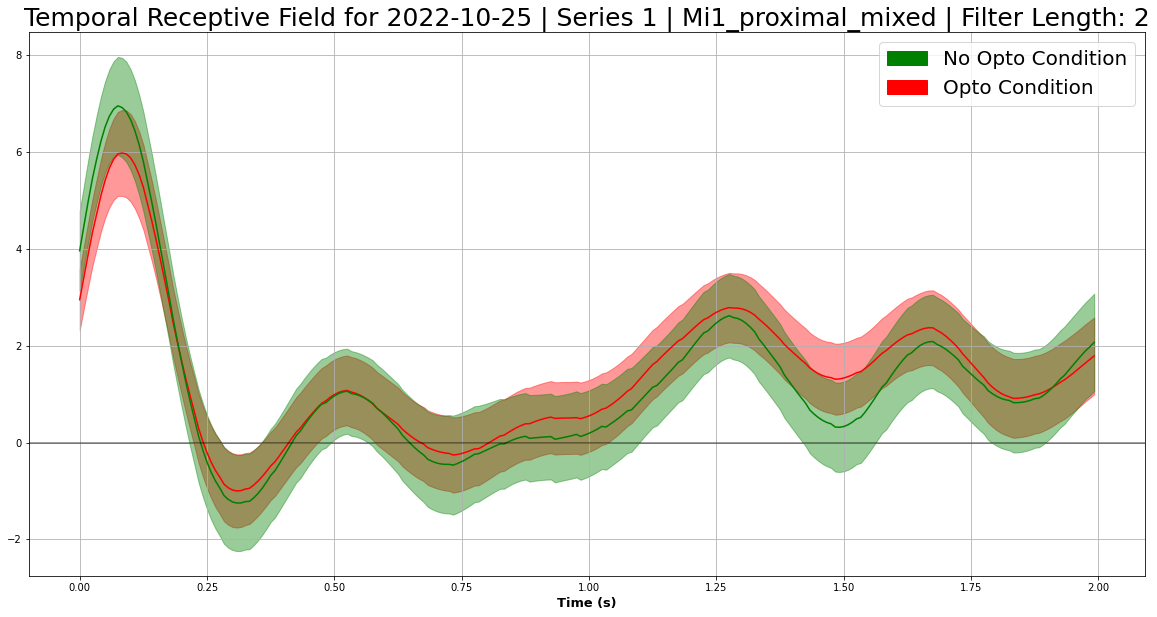

In [243]:
plotSingleTRFComparison(
                        across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus, 
                        across_roi_yopto_trf, across_roi_yopto_sem_plus, across_roi_yopto_sem_minus,
                        savefig = True
                       )

## Multiple ROI comparisons
For plotting all the rois

In [244]:
# SEM Plot for multiple ROIs!
def plotMultipleTRFComparisons(
                               nopto_mean_trf, nopto_sem_plus, nopto_sem_minus,
                               yopto_mean_trf, yopto_sem_plus, yopto_sem_minus,
                               savefig = False
                              ):
    roi_count = roi_data["epoch_response"].shape[0]

    fh, ax = plt.subplots(roi_count, 1, figsize=(10,roi_count*5))
    #time = np.arange(0, roi_trfs.shape[1])
    filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)
    for roi_ind in range(0, roi_count):
        ax[roi_ind].plot(filter_time, yopto_mean_trf[roi_ind], color="r")
        ax[roi_ind].fill_between(filter_time, yopto_sem_plus[roi_ind], yopto_sem_minus[roi_ind], color="r", alpha=0.4)
        ax[roi_ind].plot(filter_time, nopto_mean_trf[roi_ind], color="g")
        ax[roi_ind].fill_between(filter_time, nopto_sem_plus[roi_ind], nopto_sem_minus[roi_ind], color="g", alpha=0.4)
        ax[roi_ind].axhline(y=0, color="k", alpha=0.5)
        red_patch = mpatches.Patch(color="red", label="Opto Condition")
        green_patch = mpatches.Patch(color="green", label="No Opto Condition")

        ax[roi_ind].legend(handles=[green_patch, red_patch], fontsize=12)
        ax[roi_ind].set_title(
            f"Temporal Receptive Field for {experiment_file_name} | Series {series_number} | {roi_set_name}: ROI_{roi_ind+1} | Filter Length: {filter_length}",
            fontsize=12,
        )
        ax[roi_ind].set_xlabel("Time (s)", fontsize=11)
        ax[roi_ind].grid(True)

    if savefig == True:
        fh.savefig(
            save_directory
            + "Each-ROI.TemporalReceptiveField."
            + str(experiment_file_name)
            + "."
            + str(series_number)
            + "."
            + str(roi_set_name)
            + ".FilterLength"
            + str(filter_length)
            + ".pdf",
            dpi=300,
        )

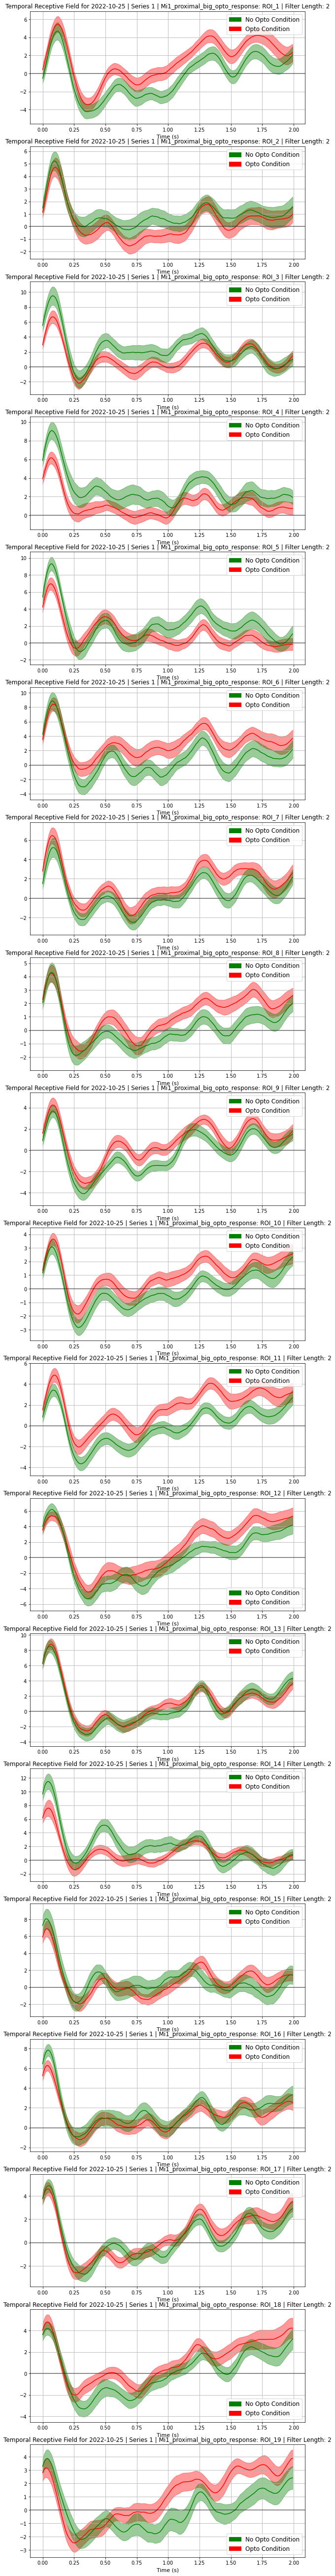

In [234]:
plotMultipleTRFComparisons(
                           nopto_mean_trf, nopto_sem_plus, nopto_sem_minus,
                           yopto_mean_trf, yopto_sem_plus, yopto_sem_minus,
                           savefig = True
                          )

# Filter in Fourier space

Text(0.5, 1.0, 'FFT Filter baby')

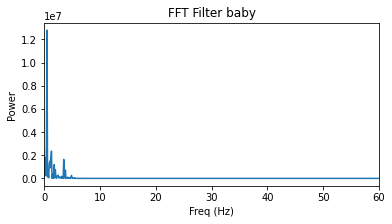

In [62]:
# FFT frequency sample points
freq = np.fft.fftfreq(n=len(filter_fft), d=1/ideal_frame_rate)

# Filter power spectrum
fh, ax = plt.subplots(1, 1, figsize=(6, 3))
# FFT shift before visualizing
ax.plot(np.fft.fftshift(freq), np.abs(np.fft.fftshift(filter_fft))**2)
# ax.plot(np.fft.fftshift(freq), np.fft.fftshift(filter_fft))

ax.set_xlim([0, 60])
# ax.set_yscale('log')
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Power')
ax.set_title('FFT Filter baby')

# Conclusion: very little power at high frequencies, no use in doing freq cutoff before ifft

# Everything Below is deprecated!

In [ ]:
parameters (same across all trials)
update_rate = run_parameters["update_rate"]
# rand_min = run_parameters['rand_min']
# rand_max = run_parameters['rand_max']
rand_min = 0
rand_max = 1

# calculate number of time points needed
n_frames = update_rate * (run_parameters["stim_time"])

# initialize array that will contain stimuli for all trials
all_stims = np.zeros((int(n_frames), int(run_parameters["num_epochs"])))
# populate all-trial stimulus array
for trial_num in range(0, int(run_parameters["num_epochs"])):
    # pull start_seed for trial
    start_seed = epoch_parameters[(trial_num)]["start_seed"]
    # initialize stimulus frames variable with full idle color
    stim = np.full(int(n_frames), run_parameters["idle_color"])
    # populate stim array (T) specifically during "stim time"
    for stim_ind in range(0, stim.shape[0]):
        # find time in sec at stim_ind
        t = stim_ind / update_rate
        # define seed at each timepoint
        seed = int(np.round(start_seed + stim_ind+1)) # +1 b/c in exp, t is 120Hz
        print(seed)
        np.random.seed(seed)
        # find random values for the current seed and write to pre-initialized stim array
        rand_values = np.random.choice(
            [rand_min, (rand_min + rand_max) / 2, rand_max], 1
        )
        stim[stim_ind] = rand_values

    # save trial stimulus to all_stims(Time, Trial)
    all_stims[:, (trial_num)] = stim

print(f'The length of the stim is {all_stims.shape[0]} and the number of trials is {all_stims.shape[1]}!')
# This is currently alternating NO OPTO and OPTO conditions

In [ ]:
# Function to randomly draw a value
def getRandVal(rand_min, rand_max, start_seed, update_rate, t):
  seed = int(round(start_seed + t*update_rate))
  np.random.seed(seed)
  return np.random.choice([rand_min, (rand_min + rand_max)/2, rand_max], size=1)[0]

# Establish relevant variables
epoch_parameters = ID.getEpochParameters()
ideal_frame_rate = 120  # Hz
sample_period = ID.getAcquisitionMetadata('sample_period') # (sec), bruker imaging acquisition period
filter_len = filter_length * ideal_frame_rate
stimulus_timing = ID.getStimulusTiming(plot_trace_flag=False)
stimulus_start_times = stimulus_timing['stimulus_start_times']
stim_frames = ID.getRunParameters('stim_time') * ideal_frame_rate

# frame flip times in a stimulus presentation:
stim_times = np.arange(1, stim_frames+1) * 1/ideal_frame_rate

all_trfs = []
all_stims = []
all_responses = []

print('Initializing: (1) visual stim recreation (2) fft responses (3) generate filters...\n')
for epoch_ind in range(int(ID.getRunParameters('num_epochs'))):
    # Regenerate the stimulus
    start_seed = epoch_parameters[epoch_ind]['start_seed']
    rand_min = eval(epoch_parameters[epoch_ind]['distribution_data'])['kwargs']['rand_min']
    rand_max = eval(epoch_parameters[epoch_ind]['distribution_data'])['kwargs']['rand_max']
    update_rate = epoch_parameters[epoch_ind]['update_rate']

    new_stim = np.array([getRandVal(rand_min, rand_max, start_seed, update_rate, t) for t in stim_times])
    current_frame_times = stimulus_start_times[epoch_ind] + stim_times  # In Prairie View time (sec)

    baseline_time = 1 # (sec) generally could be pre_time, but for opto only take previous 1 sec
    baseline_times = np.linspace(current_frame_times[0]-baseline_time, current_frame_times[0], int(1/sample_period))
    baseline = np.mean(f_interp_response(baseline_times))

    if dff == True:
        # Convert to dF/F
        current_interp_response = (f_interp_response(current_frame_times) - baseline) / baseline
    else: # don't df/f
        current_interp_response = f_interp_response(current_frame_times) 

    filter_fft = np.fft.fft(current_interp_response - np.mean(current_interp_response)) * np.conj(
      np.fft.fft(new_stim - np.mean(new_stim)))

    filt = np.real(np.fft.ifft(filter_fft))[0 : int(filter_len)]

    trf = np.flip(filt)
    all_trfs.append(trf)

all_trfs = np.stack(all_trfs, axis=-1)
print('\n-------')
print('DONE!')
print('-------\n')

## Max Plot

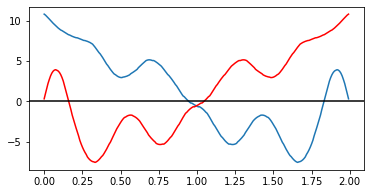

In [200]:
#filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)
time = np.arange(0, filter_len) * 1/ideal_frame_rate
filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)



fh, ax = plt.subplots(1, 1, figsize=(6, 3))
#ax.plot(filter_time, np.mean(roi_trfs[8,:,:], axis=-1))
ax.plot(time, np.mean(np.mean(roi_trfs[:,:,:], axis=-1),axis=0))
ax.plot(filter_time, np.mean(np.mean(roi_trfs[:,:,:], axis=-1), axis=0), color = 'r')

ax.axhline(y=0, color='k')

In [ ]:
#Experimental
# pull run parameters (same across all trials)
update_rate = run_parameters["update_rate"]
# rand_min = run_parameters['rand_min']
# rand_max = run_parameters['rand_max']
rand_min = 0
rand_max = 1

# calculate number of time points needed
n_frames = update_rate * (run_parameters["stim_time"])

# initialize array that will contain stimuli for all trials
all_stims = np.zeros((int(n_frames), int(run_parameters["num_epochs"])))
# populate all-trial stimulus array
for trial_num in range(0, int(run_parameters["num_epochs"])):
    # pull start_seed for trial
    start_seed = epoch_parameters[(trial_num)]["start_seed"]
    # initialize stimulus frames variable with full idle color
    stim = np.full(int(n_frames), run_parameters["idle_color"])
    # populate stim array (T) specifically during "stim time"
    for stim_ind in range(0, stim.shape[0]):
        # find time in sec at stim_ind
        t = stim_ind / update_rate
        # define seed at each timepoint
        seed = int(np.ceil(start_seed + stim_ind+1))
        print(seed)
        np.random.seed(seed)
        # find random values for the current seed and write to pre-initialized stim array
        rand_values = np.random.choice(
            [rand_min, (rand_min + rand_max) / 2, rand_max], 1
        )
        stim[stim_ind] = rand_values

    # save trial stimulus to all_stims(Time, Trial)
    all_stims[:, (trial_num)] = stim

print(f'The length of the stim is {all_stims.shape[0]} and the number of trials is {all_stims.shape[1]}!')
# This is currently alternating NO OPTO and OPTO conditions

In [92]:
print(start_seed)

74


In [85]:
# EXPERIMENTAL
# add gray to the pre and post parts of the stimulus 
pre_stim_updates = update_rate*run_parameters["pre_time"]
gray_filler = np.full((int(pre_stim_updates),num_trials), 0.5)

grayed_all_stim = np.concatenate((gray_filler, all_stims, gray_filler), axis=0)

In [102]:
from scipy import signal
sample_period = ID.getAcquisitionMetadata('sample_period')
pre_frames = run_parameters["pre_time"]/sample_period
stim_frames = run_parameters["stim_time"]/sample_period
stim_frames_end = pre_frames+stim_frames
num_trials = int(run_parameters["num_epochs"])



# Calculate TRF

In [103]:

# define filter length in seconds, convert to samples
filter_len = filter_length * run_parameters["update_rate"]

# Initialize roi_trfs - ROI x Filter x Trials
roi_trfs = np.zeros(
    (
        roi_data["epoch_response"].shape[0],
        int(filter_len),
        int(run_parameters["num_epochs"]),
    )
)


# iterate over ROIs to save STRFs and movies

for roi_id in range(0, roi_data["epoch_response"].shape[0]):


    # initialize strf by trial array (T,Tr)
    roi_trf = np.zeros((int(filter_len), int(run_parameters["num_epochs"])))
    for trial_num in range(0, int(run_parameters["num_epochs"])):
        current_resp = roi_data["epoch_response"][roi_id, trial_num]
        trimmed_current_resp = current_resp[int(pre_frames):int(stim_frames_end)]

        # initialize strf and full time series for update rate of stimulus
        full_t = np.arange(
            run_parameters["pre_time"],
            run_parameters["stim_time"] + run_parameters["pre_time"],
            1 / run_parameters["update_rate"],
        )
        trf = np.zeros(int(filter_len))
        # linearly interpolate response to match stimulus timing
        #full_resp = np.interp(full_t, roi_data["time_vector"], current_resp)
        resampled_current_resp=signal.resample(trimmed_current_resp,len(all_stims[:,-1]))


        resp_mean = np.mean(resampled_current_resp)
        resp_var = np.var(resampled_current_resp)
        # compute TRF for mean-subtracted stimulus and response
        n = all_stims.shape[1]
        ext_size = 2 * n - 1
        fsize = 2 ** np.ceil(np.log2(ext_size)).astype("int")
        vis_stim = all_stims[:, trial_num]
        vis_mean = np.mean(vis_stim)
        filter_fft = np.fft.fft(resampled_current_resp - resp_mean, fsize) * np.conj(
            np.fft.fft(vis_stim - vis_mean, fsize)
        )
        filt = np.real(np.fft.ifft(filter_fft))[0 : int(filter_len)]
        trf = np.flip(filt)
        roi_trf[:, trial_num] = trf

    roi_trfs[roi_id, :, :] = roi_trf


# SPLIT into NO Opto and YES Opto trials (alternating)
no_slice = roi_trfs[:, :, 0::2]  # Every 2 trials, starting at 0
yes_slice = roi_trfs[:, :, 1::2]  # Every 2 trials, starting at 1

# compute mean STRF
# roi_mean_strf = np.mean(roi_strf,3);
roi_mean_trf = np.mean(roi_trfs, 2)
nopto_mean_trf = np.mean(no_slice, 2)
yopto_mean_trf = np.mean(yes_slice, 2)

# Standard Error of the Mean calculations
nopto_sem = sem(no_slice, axis=2)  # calculate the no opto sem
nopto_sem_plus = np.squeeze(nopto_mean_trf + nopto_sem)
nopto_sem_minus = np.squeeze(nopto_mean_trf - nopto_sem)
yopto_sem = sem(yes_slice, axis=2)  # calculate the yes opto sem
yopto_sem_plus = np.squeeze(yopto_mean_trf + yopto_sem)
yopto_sem_minus = np.squeeze(yopto_mean_trf - yopto_sem)

# Checking ouputs for separating no opto from opto trials
print("\n---------------------------------------------------------------------")
print("---------------------------------------------------------------------")
print("Checking the shape of the various trfs to ensure opto/no opto split!")
print("Shape of roi_trfs is: " + str(roi_trfs.shape))
print("Shape of no_slice is: " + str(no_slice.shape))
print("Shape of yes_slice is: " + str(yes_slice.shape))

print("\nShape of roi_mean_trf is: " + str(roi_mean_trf.shape))
print("Shape of nopto_mean_trf is: " + str(nopto_mean_trf.shape))
print("Shape of yopto_mean_trf is: " + str(yopto_mean_trf.shape))


---------------------------------------------------------------------
---------------------------------------------------------------------
Checking the shape of the various trfs to ensure opto/no opto split!
Shape of roi_trfs is: (1, 80, 150)
Shape of no_slice is: (1, 80, 75)
Shape of yes_slice is: (1, 80, 75)

Shape of roi_mean_trf is: (1, 80)
Shape of nopto_mean_trf is: (1, 80)
Shape of yopto_mean_trf is: (1, 80)


# Testing 

In [90]:
#cxzfgvcv

# Plot TRF

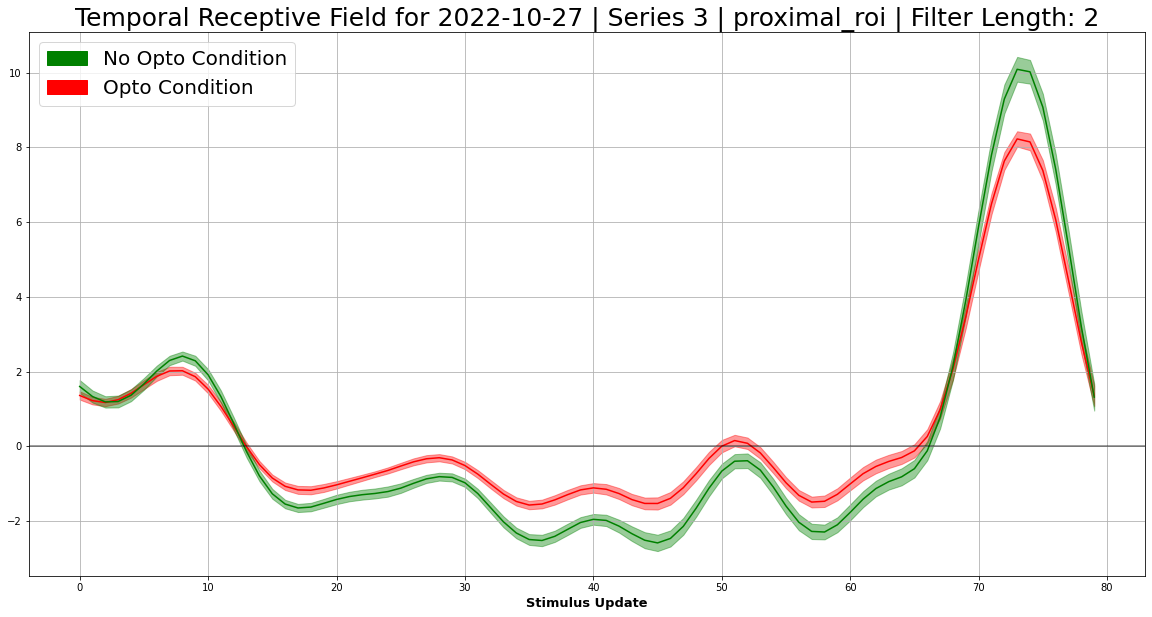

In [104]:
# SEM Plot!
fh, ax = plt.subplots(1, 1, figsize=(20, 10))
time = np.arange(0, roi_trfs.shape[1])

ax.plot(time, np.squeeze(yopto_mean_trf), color="r")
ax.fill_between(time, yopto_sem_plus, yopto_sem_minus, color="r", alpha=0.4)
ax.plot(time, np.squeeze(nopto_mean_trf), color="g")
ax.fill_between(time, nopto_sem_plus, nopto_sem_minus, color="g", alpha=0.4)
ax.axhline(y=0, color="k", alpha=0.5)
red_patch = mpatches.Patch(color="red", label="Opto Condition")
green_patch = mpatches.Patch(color="green", label="No Opto Condition")

ax.legend(handles=[green_patch, red_patch], fontsize=20)
ax.set_title(
    f"Temporal Receptive Field for {experiment_file_name} | Series {series_number} | {roi_set_name} | Filter Length: {filter_length}",
    fontsize=25,
)
ax.set_xlabel("Stimulus Update", fontweight="bold", fontsize=13)
ax.grid(True)

if savefig == True:
    fh.savefig(
        save_directory
        + "TemporalReceptiveField."
        + str(experiment_file_name)
        + "."
        + str(series_number)
        + "."
        + str(roi_set_name)
        + ".FilterLength"
        + str(filter_length)
        + ".pdf",
        dpi=300,
    )

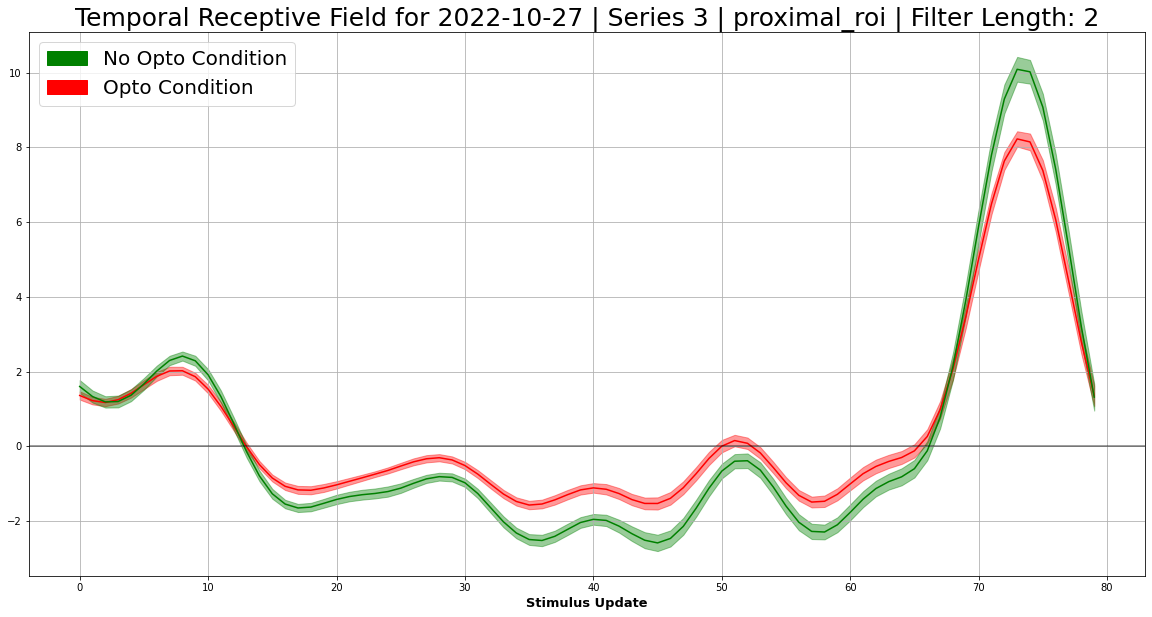

In [97]:
# SEM Plot!
fh, ax = plt.subplots(1, 1, figsize=(20, 10))
time = np.arange(0, roi_trfs.shape[1])

ax.plot(time, np.squeeze(yopto_mean_trf), color="r")
ax.fill_between(time, yopto_sem_plus, yopto_sem_minus, color="r", alpha=0.4)
ax.plot(time, np.squeeze(nopto_mean_trf), color="g")
ax.fill_between(time, nopto_sem_plus, nopto_sem_minus, color="g", alpha=0.4)
ax.axhline(y=0, color="k", alpha=0.5)
red_patch = mpatches.Patch(color="red", label="Opto Condition")
green_patch = mpatches.Patch(color="green", label="No Opto Condition")

ax.legend(handles=[green_patch, red_patch], fontsize=20)
ax.set_title(
    f"Temporal Receptive Field for {experiment_file_name} | Series {series_number} | {roi_set_name} | Filter Length: {filter_length}",
    fontsize=25,
)
ax.set_xlabel("Stimulus Update", fontweight="bold", fontsize=13)
ax.grid(True)

if savefig == True:
    fh.savefig(
        save_directory
        + "TemporalReceptiveField."
        + str(experiment_file_name)
        + "."
        + str(series_number)
        + "."
        + str(roi_set_name)
        + ".FilterLength"
        + str(filter_length)
        + ".pdf",
        dpi=300,
    )